In [4]:
### Importing all the needed libraries

from IPython.display import display
from IPython.display import Image as ImageJP

from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn import datasets
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import tensorflow
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.random_seed import set_random_seed

from urllib.request import urlopen

In [5]:
### Funciton which imports all the data from the given URL

def load_fashion_mnist():

    url_base = "https://www.math.unipd.it/~dasan/"
    y_train = np.frombuffer(urlopen(url_base + "train-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_train = np.frombuffer(urlopen(url_base + "train-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)
    y_test = np.frombuffer(urlopen(url_base + "t10k-labels-idx1-ubyte").read(), dtype=np.uint8, offset=8)
    X_test = np.frombuffer(urlopen(url_base + "t10k-images-idx3-ubyte").read(), dtype=np.uint8, offset=16).reshape(len(y_test), 784)

    return X_train, y_train, X_test, y_test

In [6]:
### Splitting the data into training, validation and test set

X_train_val, y_train_val, X_test, y_test = load_fashion_mnist()
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify = y_train_val, random_state = 123)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(48000, 784) (48000,) (12000, 784) (12000,) (10000, 784) (10000,)


In [7]:
### Functions that allow to transform the dataframe according to the needs

def dataframe_memoryview_to_float32(dataframe):
    for col in dataframe.columns:
        if type(dataframe[col][0]) == memoryview:
            dataframe[col] = dataframe[col].apply(float32)
    return dataframe

def dataframe_memoryview_to_int64(dataframe):
    for col in dataframe.columns:
        if type(dataframe[col][0]) == memoryview:
            dataframe[col] = dataframe[col].apply(imt64)
    return dataframe

In [9]:
### Inserting the data into Pandas dataframes

X_train_val = pd.DataFrame(X_train_val)
y_train_val = pd.DataFrame(y_train_val)

X_train_val = dataframe_memoryview_to_float32(X_train_val)
y_train_val = dataframe_memoryview_to_int64(y_train_val)

X_train_val = np.array(X_train_val, dtype= float)

X_train_val /= 255.0

In [10]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X_train = dataframe_memoryview_to_float32(X_train)
y_train = dataframe_memoryview_to_int64(y_train)

X_train = np.array(X_train, dtype= float)

X_train /= 255.0

In [11]:
X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)

X_val = dataframe_memoryview_to_float32(X_val)
y_val = dataframe_memoryview_to_int64(y_val)

X_val = np.array(X_val, dtype= float)

X_val /= 255.0

In [12]:
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

X_test = dataframe_memoryview_to_float32(X_test)
y_test = dataframe_memoryview_to_int64(y_test)

X_test = np.array(X_test, dtype = float)

X_test /= 255.0

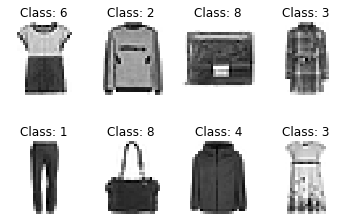

In [13]:
### Representing the data

fig, axes = plt.subplots(nrows=2, ncols=4)
k = 0
for j in range(4):
    for i in range(2):
        axes[i][j].set_axis_off()
        axes[i][j].imshow(X_train[k].reshape(28,28), cmap = plt.cm.gray_r, interpolation = 'nearest')
        axes[i][j].set_title("Class: %i" % y_train[0][k])
        k += 1

In [16]:
### DECISION TREE
### Training of a decision tree classification algorithm, with various hyperparameters

dt_grid_params = {'criterion': ('entropy', 'gini'), 'max_depth': (5, 10, 11, 15)}

dt_clf = DecisionTreeClassifier(random_state = 123)
dt_v1 = GridSearchCV(dt_clf, dt_grid_params, n_jobs= -1, cv = 5)
dt_v1.fit(X_train, y_train)

print('Parameters: ', dt_v1.best_params_)
print('Scores: ', dt_v1.best_score_)


Parameters:  {'criterion': 'gini', 'max_depth': 11}
Scores:  0.8104166666666666


In [ ]:
### Predictions of classification tree with the final score over training, validation and test set

y_train_pred_dt = dt_v1.predict(X_train)
y_val_pred_dt = dt_v1.predict(X_val)
print(f"Decision Tree.\tTrain:{f1_score(y_train, y_train_pred_dt,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred_dt,average = 'macro'):.4f}")

y_test_pred_dt = dt_v1.predict(X_test)
print(f"Decision Tree.\tTest:{f1_score(y_test, y_test_pred_dt,average = 'macro'):.4f}")


Decision Tree.	Train:0.8959	Val:0.8108
Decision Tree.	Test:0.8063


In [ ]:
### RANDOM FOREST
### Training of a random forest classification algorithm, with various hyperparameters

rf_grid_params = {'n_estimators': (100, 300, 500), 'criterion': ['entropy'], 'max_depth': (100, 300, 500)}

rf_clf = RandomForestClassifier(random_state = 123)
rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
rf_v1.fit(X_train, y_train)

print('Parameters: ', rf_v1.best_params_)
print('Scores: ', rf_v1.best_score_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Parameters:  {'criterion': 'entropy', 'max_depth': 300, 'n_estimators': 300}
Scores:  0.8821875


In [ ]:
### Predictions of random forest with the final score over training, validation and test set

y_train_pred_rf = rf_v1.predict(X_train)
y_val_pred_rf = rf_v1.predict(X_val)
print(f"Random Forest.\tTrain:{f1_score(y_train, y_train_pred_rf,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred_rf,average = 'macro'):.4f}")

y_test_pred_rf = rf_v1.predict(X_test)
print(f"Random Forest.\tTest:{f1_score(y_test, y_test_pred_rf,average = 'macro'):.4f}")

Random Forest.	Train:1.0000	Val:0.8857
Random Forest.	Test:0.8737


In [ ]:
### SVC
### Training of a SVC classification algorithm, with various hyperparameters

linearsvc_grid_params = {'C': (0.1, 1, 10, 13, 15)}

linearsvc_clf = SVC(random_state = 123)
svc_v1 = GridSearchCV(linearsvc_clf, linearsvc_grid_params, n_jobs= -1, cv = 5)
svc_v1.fit(X_train, y_train)

print('Parameters: ', svc_v1.best_params_)
print('Scores: ', svc_v1.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Parameters:  {'C': 13}
Scores:  0.9008750000000001


In [ ]:
### Predictions of SVC with the final score over training, validation and test set

y_train_pred_svc = svc_v1.predict(X_train)
y_val_pred_svc = svc_v1.predict(X_val)
print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred_svc,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred_svc,average = 'macro'):.4f}")

y_test_pred_svc = svc_v1.predict(X_test)
print(f"SVC.\tTest:{f1_score(y_test, y_test_pred_svc, average = 'macro'):.4f}")

SVC.	Train:0.9788	Val:0.8994
SVC.	Test:0.8954


In [ ]:
### Computing the results of the three algorithms over each one of the 10 result labels, using three different metrics

print(classification_report(y_test, y_test_pred_dt))
print(classification_report(y_test, y_test_pred_rf))
print(classification_report(y_test, y_test_pred_svc))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75      1000
           1       0.96      0.95      0.95      1000
           2       0.66      0.72      0.69      1000
           3       0.84      0.80      0.82      1000
           4       0.66      0.69      0.68      1000
           5       0.93      0.88      0.90      1000
           6       0.58      0.52      0.55      1000
           7       0.84      0.92      0.88      1000
           8       0.93      0.93      0.93      1000
           9       0.93      0.90      0.92      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.79      0.78      1000
           3       0.87 

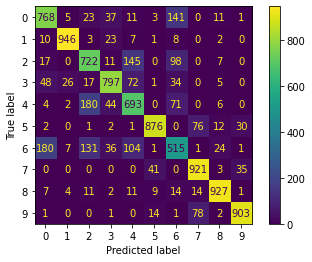

In [ ]:
### Confusion matrix of the decision tree classifier

dt_cm = confusion_matrix(y_test, y_test_pred_dt, labels=dt_v1.classes_)
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=dt_v1.classes_)
dt_disp.plot()
plt.show()

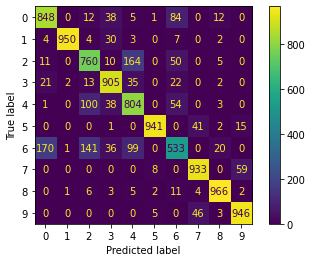

In [ ]:
### Confusion matrix of the random forest classifier

rf_cm = confusion_matrix(y_test, y_test_pred_rf, labels=rf_v1.classes_)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_v1.classes_)
rf_disp.plot()
plt.show()

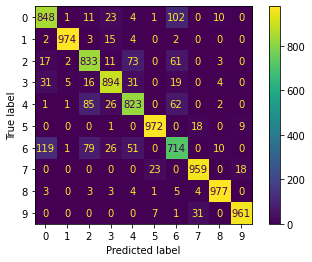

In [ ]:
### Confusion matrix of the SVC classifier

svc_cm = confusion_matrix(y_test, y_test_pred_svc, labels = svc_v1.classes_)
svc_disp = ConfusionMatrixDisplay(confusion_matrix = svc_cm, display_labels = svc_v1.classes_)
svc_disp.plot()
plt.show()

In [ ]:
### NEURAL NETWORKS
### Training the classifier using neural networks

es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, verbose=1)

feature_vector_length = X_train.shape[1]
num_classes = 10

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

np.random.seed(123)
set_random_seed(2)

In [ ]:
### After various trials and errors, best results achieved with this configuration

np.random.seed(123)
set_random_seed(2)

nn1 = Sequential()
nn1.add(Dense(input_dim = feature_vector_length, units=feature_vector_length, activation='relu'))
nn1.add(Dense(units = 350, activation = 'relu'))
nn1.add(Dense(units = 200, activation = 'relu'))
nn1.add(Dense(units = 120, activation = 'relu'))
nn1.add(Dense(units = 70, activation = 'relu'))
nn1.add(Dense(units = 40, activation = 'relu'))
nn1.add(Dense(units = 20, activation = 'relu'))
nn1.add(Dense(num_classes, activation='softmax'))

nn1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history1 = nn1.fit(X_train, y_train_cat, epochs=500, batch_size=16, verbose=0, validation_split=0.2, callbacks=[es])

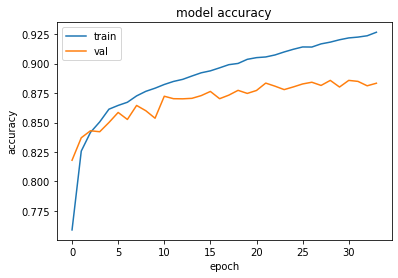

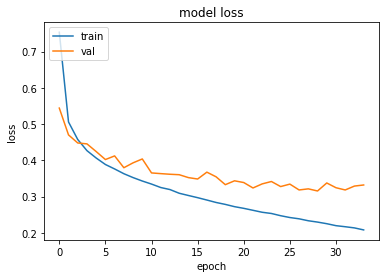

In [ ]:
### Plotting accuracy and loss throughout the training of the neural network

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
### ### Predictions of neural networks with the final score over training, validation and test set

y_train_pred_nn =nn1.predict(X_train).argmax(axis = 1) 
y_val_pred_nn = nn1.predict(X_val).argmax(axis = 1)
print(f"NN.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tValidation:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

y_test_pred_nn = nn1.predict(X_test).argmax(axis = 1)
print(f"NN.\tTest:{f1_score(y_test, y_test_pred,average = 'macro'):.4f}")

NN.	Train:0.9154	Validation:0.8829


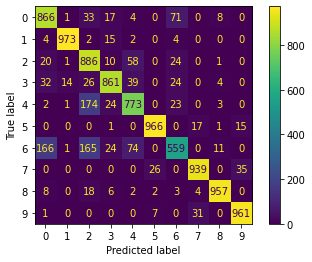

In [ ]:
### Confusion matrix of the neural network classifier

nn1_cm = confusion_matrix(y_test, y_test_pred_nn)
nn1_disp = ConfusionMatrixDisplay(confusion_matrix = nn1_cm)
nn1_disp.plot()
plt.show()

In [ ]:
### LOGISTIC REGRESSION
### Training of a logisitic regression classifier using various hyperparameters

lr_grid_params = {'penalty': ['l2'], 'C': (0.1, 1, 10), 'max_iter': [1000]}

lr_clf = LogisticRegression(random_state = 123, verbose= True)
lr_v1 = GridSearchCV(lr_clf, lr_grid_params, n_jobs = -1, cv = 5)
lr_v1.fit(X_train, y_train)

print('Parameters: ', lr_v1.best_params_)
print('Scores: ', lr_v1.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Parameters:  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}
Scores:  0.8560000000000001


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min finished


In [ ]:
### Prediction and score on the training, validation and test sets

y_train_pred_lr = lr_v1.predict(X_train)
y_val_pred_lr = lr_v1.predict(X_val)
print(f"SVC.\tTrain:{f1_score(y_train, y_train_pred_lr,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred_lr,average = 'macro'):.4f}")

y_test_pred_lr = lr_v1.predict(X_test)
print(f"SVC.\tTest:{f1_score(y_test, y_test_pred_lr, average = 'macro'):.4f}")

SVC.	Train:0.8738	Val:0.8561
SVC.	Test:0.8412
